<a href="https://colab.research.google.com/github/Dhairya-k1/Autonomous-Vehicle-Perception-Module/blob/main/Autonomous_Vehicle_Perception_Module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PHASE 1 : LANE DETECTION

In [ ]:
import kagglehub

# Download dataset
DATASET_PATH = kagglehub.dataset_download("thomasfermi/lane-detection-for-carla-driving-simulator")

print("Path to dataset files:", DATASET_PATH)

100%|██████████| 1.88G/1.88G [00:22<00:00, 89.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/thomasfermi/lane-detection-for-carla-driving-simulator/versions/1


## Load images




In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import os

train_data = []

train_folder_path = os.path.join(DATASET_PATH, "train")

for img_name in os.listdir(train_folder_path):
  img_path = os.path.join(train_folder_path, img_name)

  if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
    train_img = cv2.imread(img_path)

    if train_img is not None:
      train_data.append(train_img)

train_data = np.array(train_data)

if(len(train_data)):
  print("Data added sucessfully")
else:
  print("Data not added")

Data added sucessfully


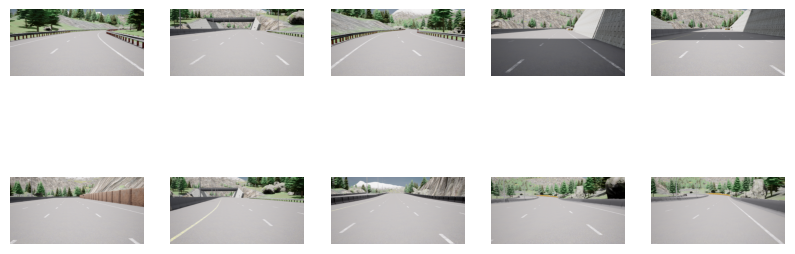

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_data[i])
    plt.axis('off')
plt.show()

## Lane Detection


In [ ]:
! pip install segmentation-models-pytorch albumentations
! pip install albumentations segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from glob import glob
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp


TARGET_SIZE = (256, 512)
CLASSES = 3 # Output Class
# Hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_PATHS = sorted(glob(os.path.join(DATASET_PATH, IMAGE_FOLDER, "*.png")))
MASK_PATHS = sorted(glob(os.path.join(DATASET_PATH, MASK_FOLDER, "*.png")))
DATASET_SIZE = len(IMAGE_PATHS)

ALBU_TRANSFORM = A.Compose([
    A.Resize(TARGET_SIZE[0], TARGET_SIZE[1], interpolation=cv2.INTER_NEAREST),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

def load_and_preprocess_item(idx, image_paths, mask_paths, transform_pipeline):

    img = cv2.imread(image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_paths[idx], cv2.IMREAD_GRAYSCALE)


    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    sample = transform_pipeline(image=img, mask=mask)

    img_tensor = sample['image']
    mask_tensor = sample['mask']

    return img_tensor, mask_tensor.long()

print("\n--- Model Definition ---")
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=CLASSES,               # 3 output classes (0: Background, 1: Left, 2: Right)
)
model.to(DEVICE)
print("U-Net model initialized with ResNet34 encoder")

criterion = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print("Dice Loss usually provides smoother gradients for thin, imbalanced structures like lanes")

if DATASET_SIZE > 0:
    print("\nStarting Training Loop")

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        total_loss = 0.0

        num_batches = DATASET_SIZE // BATCH_SIZE

        for i in tqdm(range(num_batches), desc=f"Epoch {epoch}/{NUM_EPOCHS}"):


            batch_images = []
            batch_masks = []

            for j in range(BATCH_SIZE):
                idx = i * BATCH_SIZE + j
                try:
                    img, mask = load_and_preprocess_item(idx, IMAGE_PATHS, MASK_PATHS, ALBU_TRANSFORM)
                    batch_images.append(img)
                    batch_masks.append(mask)
                except IndexError:
                    break

            if not batch_images:
                continue

            images = torch.stack(batch_images).to(DEVICE)
            masks = torch.stack(batch_masks).to(DEVICE)

            optimizer.zero_grad()

            output = model(images)

            # Calculate loss
            loss = criterion(output, masks)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch} finished. Average Training Loss: {avg_loss:.4f}")

    MODEL_SAVE_PATH = "unet_carla_lane_model.pth"
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\n Training complete. Model weights saved to {MODEL_SAVE_PATH}")

else:
    print("\nNo data found")


--- Model Definition ---
U-Net model initialized with ResNet34 encoder.
Dice Loss usually provides smoother gradients for thin, imbalanced structures like lanes.

--- Starting Training Loop ---


Epoch 1/20: 100%|██████████| 384/384 [02:19<00:00,  2.75it/s]


Epoch 1 finished. Average Training Loss: 0.6624


Epoch 2/20: 100%|██████████| 384/384 [02:17<00:00,  2.79it/s]


Epoch 2 finished. Average Training Loss: 0.6238


Epoch 3/20: 100%|██████████| 384/384 [02:17<00:00,  2.80it/s]


Epoch 3 finished. Average Training Loss: 0.6169


Epoch 4/20: 100%|██████████| 384/384 [02:17<00:00,  2.79it/s]


Epoch 4 finished. Average Training Loss: 0.6147


Epoch 5/20: 100%|██████████| 384/384 [02:17<00:00,  2.80it/s]


Epoch 5 finished. Average Training Loss: 0.6122


Epoch 6/20: 100%|██████████| 384/384 [02:16<00:00,  2.80it/s]


Epoch 6 finished. Average Training Loss: 0.6123


Epoch 7/20: 100%|██████████| 384/384 [02:17<00:00,  2.80it/s]


Epoch 7 finished. Average Training Loss: 0.6114


Epoch 8/20: 100%|██████████| 384/384 [02:16<00:00,  2.81it/s]


Epoch 8 finished. Average Training Loss: 0.6087


Epoch 9/20: 100%|██████████| 384/384 [02:17<00:00,  2.80it/s]


Epoch 9 finished. Average Training Loss: 0.6090


Epoch 10/20: 100%|██████████| 384/384 [02:17<00:00,  2.80it/s]


Epoch 10 finished. Average Training Loss: 0.6079


Epoch 11/20: 100%|██████████| 384/384 [02:16<00:00,  2.80it/s]


Epoch 11 finished. Average Training Loss: 0.6063


Epoch 12/20: 100%|██████████| 384/384 [02:17<00:00,  2.80it/s]


Epoch 12 finished. Average Training Loss: 0.6037


Epoch 13/20: 100%|██████████| 384/384 [02:16<00:00,  2.81it/s]


Epoch 13 finished. Average Training Loss: 0.6001


Epoch 14/20: 100%|██████████| 384/384 [02:17<00:00,  2.80it/s]


Epoch 14 finished. Average Training Loss: 0.5976


Epoch 15/20: 100%|██████████| 384/384 [02:16<00:00,  2.80it/s]


Epoch 15 finished. Average Training Loss: 0.5936


Epoch 16/20: 100%|██████████| 384/384 [02:19<00:00,  2.76it/s]


Epoch 16 finished. Average Training Loss: 0.5878


Epoch 17/20: 100%|██████████| 384/384 [02:18<00:00,  2.77it/s]


Epoch 17 finished. Average Training Loss: 0.5813


Epoch 18/20: 100%|██████████| 384/384 [02:17<00:00,  2.78it/s]


Epoch 18 finished. Average Training Loss: 0.5764


Epoch 19/20: 100%|██████████| 384/384 [02:18<00:00,  2.78it/s]


Epoch 19 finished. Average Training Loss: 0.5646


Epoch 20/20: 100%|██████████| 384/384 [02:18<00:00,  2.78it/s]

Epoch 20 finished. Average Training Loss: 0.5544

✅ Training complete. Model weights saved to unet_carla_lane_model.pth


In [ ]:
if DATASET_SIZE > 0:
    idx_to_load = 5
    print(f"\n        Demonstrating Loading Item {idx_to_load}     ")

    image_tensor, mask_tensor = load_and_preprocess(
           idx_to_load, IMAGE_PATHS, MASK_PATHS, ALBU_TRANSFORM
    )

    print(f"Successfully loaded image and mask for index {idx_to_load}")
    print(f"Image Tensor Shape: {image_tensor.shape} (C, H, W)")
    print(f"Mask Tensor Shape: {mask_tensor.shape} (H, W) - To calculate loss")
    print(f"Mask Data Type: {mask_tensor.dtype}")
    print(f"Unique class IDs in mask (sample): {torch.unique(mask_tensor)}")


Dataset size: 3075 x2 including mask images also

        Demonstrating Loading Item 5     
Successfully loaded image and mask for index 5
Image Tensor Shape: torch.Size([3, 512, 256]) (C, H, W)
Mask Tensor Shape: torch.Size([512, 256]) (H, W) - To calculate loss
Mask Data Type: torch.int64
Unique class IDs in mask (sample): tensor([0, 1, 2])


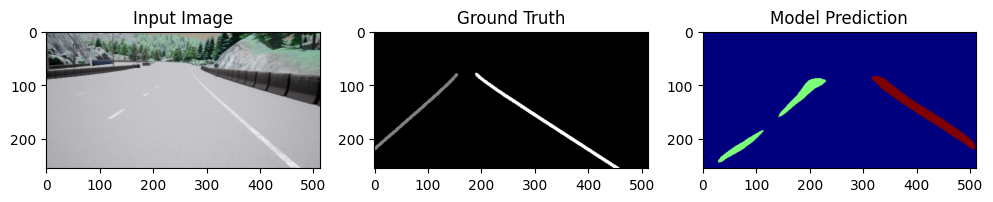

In [ ]:
import matplotlib.pyplot as plt

img, mask = load_and_preprocess_item(10, IMAGE_PATHS, MASK_PATHS, ALBU_TRANSFORM)
pred = model(img.unsqueeze(0).to(DEVICE)).argmax(dim=1).cpu().squeeze()

disp_img = (img.permute(1, 2, 0).cpu().numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(disp_img); ax1.set_title("Input Image")
ax2.imshow(mask, cmap='gray'); ax2.set_title("Ground Truth")
ax3.imshow(pred, cmap='jet'); ax3.set_title("Model Prediction"); plt.show()